In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter


### Importing Data

In [2]:
df = pd.read_csv('./export_data.csv')
del df['Unnamed: 0']
df

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,507503046389541339,5602163,2020-11-11 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0
28081,922901049461347211,5602163,2020-10-20 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0
28082,998500453066618518,5602163,2020-10-13 03:00:00,88092,102,101694,NL,0,1,50.00,50.00,2020-09-26 13:43:30,m,44.0
28083,121761332613496860,5526080,2020-10-23 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-19 11:47:32,f,37.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28085 entries, 0 to 28084
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rra_id                  28085 non-null  int64  
 1   rra_playerId            28085 non-null  int64  
 2   rra_dateAt              28085 non-null  object 
 3   rra_partnerId           28085 non-null  int64  
 4   rra_brandId             28085 non-null  int64  
 5   rra_campaignId          28085 non-null  int64  
 6   rra_playerCountry       28085 non-null  object 
 7   rra_registrationsCount  28085 non-null  int64  
 8   rra_depositsCount       28085 non-null  int64  
 9   firstDepositsSumEur     28085 non-null  float64
 10  depositsSumEur          28085 non-null  float64
 11  c_registrationDateAt    28085 non-null  object 
 12  c_gender                28085 non-null  object 
 13  c_age                   28085 non-null  float64
dtypes: float64(3), int64(7), object(4)
mem

# Data Analysis

In [4]:
df.dtypes

rra_id                      int64
rra_playerId                int64
rra_dateAt                 object
rra_partnerId               int64
rra_brandId                 int64
rra_campaignId              int64
rra_playerCountry          object
rra_registrationsCount      int64
rra_depositsCount           int64
firstDepositsSumEur       float64
depositsSumEur            float64
c_registrationDateAt       object
c_gender                   object
c_age                     float64
dtype: object

In [5]:
df['rra_dateAt'] = pd.to_datetime(df['rra_dateAt'])
df['c_registrationDateAt'] = pd.to_datetime(df['c_registrationDateAt'])

In [6]:
# Один способ разделения на когорты
def f(row):
    if row >= pd.to_datetime('2020-09-01') and row < pd.to_datetime('2020-09-08'):
        val = 1
    elif row >= pd.to_datetime('2020-09-08') and row < pd.to_datetime('2020-09-15'):
        val = 2
    elif row >= pd.to_datetime('2020-09-15') and row < pd.to_datetime('2020-09-22'):
        val = 3
    elif row >= pd.to_datetime('2020-09-22') and row < pd.to_datetime('2020-09-30'):
        val = 4
    else:
        val = 0
    return val

df['registration_week'] = df['c_registrationDateAt'].apply(f)

In [7]:
# Другой способ
conditions = [
    (df['c_registrationDateAt'] >= pd.to_datetime('2020-09-01')) & (df['c_registrationDateAt'] < pd.to_datetime('2020-09-08')),
    (df['c_registrationDateAt'] >= pd.to_datetime('2020-09-08')) & (df['c_registrationDateAt'] < pd.to_datetime('2020-09-15')),
    (df['c_registrationDateAt'] >= pd.to_datetime('2020-09-15')) & (df['c_registrationDateAt'] < pd.to_datetime('2020-09-22')),
    (df['c_registrationDateAt'] >= pd.to_datetime('2020-09-22')) & (df['c_registrationDateAt'] < pd.to_datetime('2020-09-30'))
    ]
values = [1, 2, 3, 4]

df['registration_week'] = np.select(conditions, values)

In [8]:
# Колонки для сводника
pivot_columns = ['rra_id',
                 'rra_registrationsCount',
                 'rra_depositsCount',
                 'firstDepositsSumEur',
                 'depositsSumEur']
pivot_columns

['rra_id',
 'rra_registrationsCount',
 'rra_depositsCount',
 'firstDepositsSumEur',
 'depositsSumEur']

In [9]:
# Строим сводную таблицу с основными метриками, сгруппированную по когортам
pivot = pd.pivot_table(df, values=pivot_columns, index=['registration_week'],
                    aggfunc={'rra_id' : 'count',
                             'rra_registrationsCount' : 'sum',
                             'rra_depositsCount' : 'sum',
                             'firstDepositsSumEur' : 'mean',
                             'depositsSumEur' : 'mean'})
pivot

,depositsSumEur,firstDepositsSumEur,rra_depositsCount,rra_id,rra_registrationsCount
registration_week,,,,,
1,63.502509,7.604851,9073,7026,1406
2,69.241334,7.731426,9559,7172,1332
3,64.013970,7.296915,8297,6970,1165
4,76.797111,8.142271,8399,6917,1331


In [10]:
# Смотрим долю клиентов, сделавших транзакцию в первый же день, от всех зарегестрированных клиентов
pivot['1st_day_deposit_share'] = pivot['rra_registrationsCount']/pivot['rra_id']

pivot.round(2)

,depositsSumEur,firstDepositsSumEur,rra_depositsCount,rra_id,rra_registrationsCount,1st_day_deposit_share
registration_week,,,,,,
1,63.50,7.60,9073,7026,1406,0.20
2,69.24,7.73,9559,7172,1332,0.19
3,64.01,7.30,8297,6970,1165,0.17
4,76.80,8.14,8399,6917,1331,0.19


In [11]:
# делаем сводник по платформе
pivot_platform = pd.pivot_table(df, values=pivot_columns, index=['registration_week', 'rra_brandId'],
                    aggfunc={'rra_id' : 'count',
                             'rra_registrationsCount' : 'sum',
                             'rra_depositsCount' : 'sum',
                             'firstDepositsSumEur' : 'mean',
                             'depositsSumEur' : 'mean'})
pivot_platform

depositsSumEur  firstDepositsSumEur  \
registration_week rra_brandId                                        
1                 99                40.684095             6.472063   
                  102               91.921608             9.015676   
2                 99                72.294848             5.799243   
                  102               65.523111            10.084221   
3                 99                54.323476             5.611115   
                  102               72.248832             8.729488   
4                 99                49.627289             6.321376   
                  102               97.193389             9.509210   

                               rra_depositsCount  rra_id  \
registration_week rra_brandId                              
1                 99                        4753    3897   
                  102                       4320    3129   
2                 99                        5487    3938   
                  102                       4072    3234   
3                 99                        3655    3202   
                  102                       4642    3768   
4                 99                        3537    2966   
                  102                       4862    3951   

                               rra_registrationsCount  
registration_week rra_brandId                          
1                 99                              725  
                  102                             681  
2                 99                              601  
                  102                             731  
3                 99                              475  
                  102                             690  
4                 99                              483  
                  102                             848

In [12]:
# смотрим топ-20 когорт/платформ по кол-ву депозитов на клиентов(Отсортированно по убыванию)
pivot_platform.nlargest(20, 'rra_depositsCount')

,,depositsSumEur,firstDepositsSumEur,rra_depositsCount,rra_id,rra_registrationsCount
registration_week,rra_brandId,,,,,
2,99,72.294848,5.799243,5487,3938,601
4,102,97.193389,9.509210,4862,3951,848
1,99,40.684095,6.472063,4753,3897,725
3,102,72.248832,8.729488,4642,3768,690
1,102,91.921608,9.015676,4320,3129,681
2,102,65.523111,10.084221,4072,3234,731
3,99,54.323476,5.611115,3655,3202,475
4,99,49.627289,6.321376,3537,2966,483


In [13]:
# делаем сводник по странам
pivot_country = pd.pivot_table(df, values=pivot_columns, index=['registration_week', 'rra_playerCountry'],
                    aggfunc={'rra_id' : 'count',
                             'rra_registrationsCount' : 'sum',
                             'rra_depositsCount' : 'sum',
                             'firstDepositsSumEur' : 'mean',
                             'depositsSumEur' : 'mean'})
pivot_country

depositsSumEur  firstDepositsSumEur  \
registration_week rra_playerCountry                                        
1                 AT                      97.394286            14.428571   
                  AU                      42.818565             6.331120   
                  AW                      10.000000            10.000000   
                  BG                       4.000000             4.000000   
                  BR                      18.440000            18.440000   
...                                             ...                  ...   
4                 PT                      69.814000             2.000000   
                  RO                      10.000000            10.000000   
                  RS                       6.666667             6.666667   
                  SI                      19.000000             5.000000   
                  ZA                      11.250000            11.250000   

                                     rra_depositsCount  rra_id  \
registration_week rra_playerCountry                              
1                 AT                                34      35   
                  AU                              3714    2955   
                  AW                                 1       2   
                  BG                                 1       5   
                  BR                                 2       2   
...                                                ...     ...   
4                 PT                                27      10   
                  RO                                 1       1   
                  RS                                 1       3   
                  SI                                 4       5   
                  ZA                                 2       4   

                                     rra_registrationsCount  
registration_week rra_playerCountry                          
1                 AT                                      7  
                  AU                                    533  
                  AW                                      1  
                  BG                                      1  
                  BR                                      1  
...                                                     ...  
4                 PT                                      1  
                  RO                                      1  
                  RS                                      1  
                  SI                                      1  
                  ZA                                      2  

[117 rows x 5 columns]

In [14]:
# смотрим топ-20 когорт/стран по кол-ву депозитов на клиентов
pivot_country.nlargest(20, 'rra_depositsCount')

,,depositsSumEur,firstDepositsSumEur,rra_depositsCount,rra_id,rra_registrationsCount
registration_week,rra_playerCountry,,,,,
4,NL,104.106445,7.312715,3954,3201,604
3,NL,75.083516,7.110066,3913,3049,502
2,AU,76.595989,4.898334,3791,2984,401
1,AU,42.818565,6.331120,3714,2955,533
3,AU,51.032211,5.137874,3121,2686,377
2,NL,73.518233,7.566907,2956,2037,420
1,NL,99.823645,7.935039,2877,2159,463
4,AU,47.771164,5.655311,2525,2216,336
2,CA,75.073485,5.766944,881,396,40


## Visualization

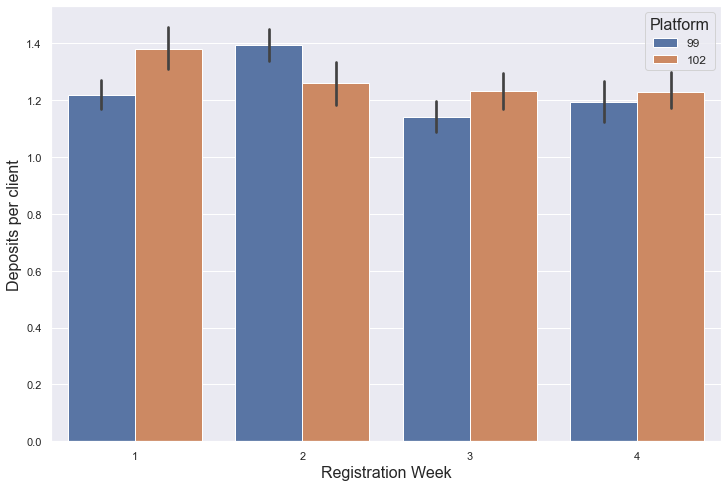

In [15]:
# Колв-во депозитов на клиента по когортам/платформе

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')


sns.barplot(x='registration_week', y='rra_depositsCount', hue='rra_brandId', data=df)
plt.xlabel('Registration Week', fontsize=16)
plt.ylabel('Deposits per client', fontsize=16)
plt.legend(title='Platform', title_fontsize='16', fontsize='12');

In [16]:
df

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,registration_week
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0,3
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0,3
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0,3
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0,3
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,507503046389541339,5602163,2020-11-11 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4
28081,922901049461347211,5602163,2020-10-20 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4
28082,998500453066618518,5602163,2020-10-13 03:00:00,88092,102,101694,NL,0,1,50.00,50.00,2020-09-26 13:43:30,m,44.0,4
28083,121761332613496860,5526080,2020-10-23 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-19 11:47:32,f,37.0,3


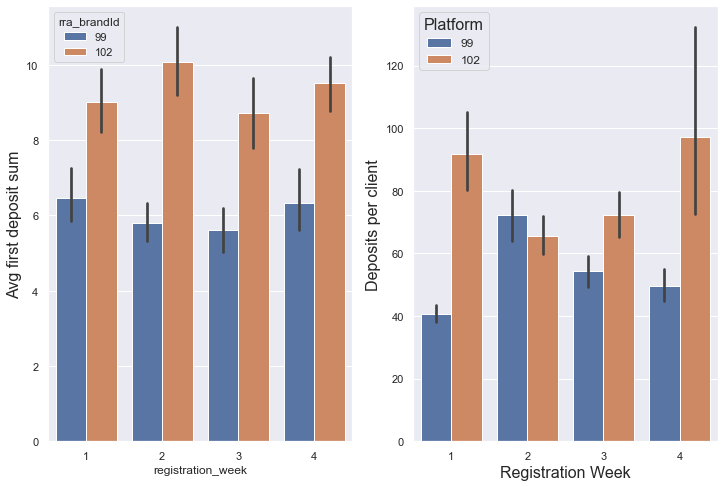

In [17]:
# Cредняя сумма первого депозита на клиента по когортам/платформе

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')

fig, axs = plt.subplots(ncols=2)
sns.barplot(x='registration_week', y='firstDepositsSumEur', hue='rra_brandId', data=df, ax=axs[0])
sns.barplot(x='registration_week', y='depositsSumEur', hue='rra_brandId', data=df, ax=axs[1])
plt.xlabel('Registration Week', fontsize=16)
axs[1].set_ylabel('Deposits per client', fontsize=16)
axs[0].set_ylabel('Avg first deposit sum', fontsize=16)
plt.legend(title='Platform', title_fontsize='16', fontsize='12');

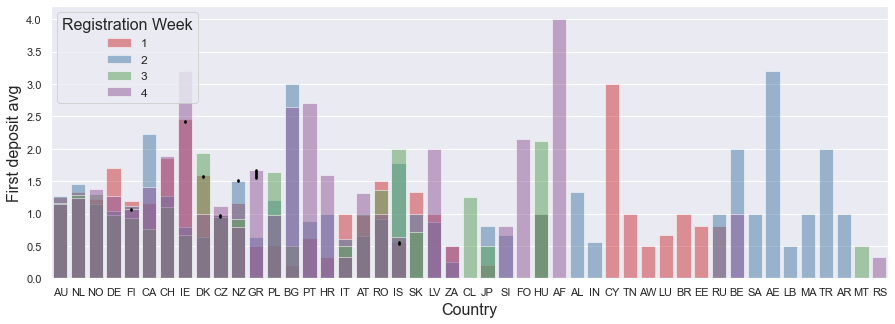

In [18]:
# Колв-во депозитов на клиента по когортам/стране

f, ax = plt.subplots(figsize=(15, 5))
sns.set_style('darkgrid')

sns.set_palette("pastel", 4)
sns.barplot(x='rra_playerCountry', y='rra_depositsCount', hue='registration_week', data=df, dodge=False, alpha=0.5, palette='Set1',
           ci=0.5, errcolor='black')
plt.xlabel('Country', fontsize=16)
plt.ylabel('First deposit avg', fontsize=16)
plt.legend(title='Registration Week', title_fontsize='16', fontsize='12');

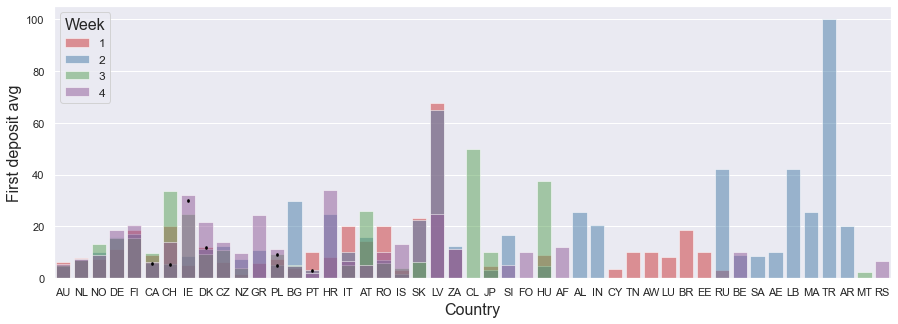

In [19]:
# Cредняя сумма первого депозита на клиента по когортам/стране

f, ax = plt.subplots(figsize=(15, 5))
sns.set_style('darkgrid')

sns.set_palette("pastel", 4)
sns.barplot(x='rra_playerCountry', y='firstDepositsSumEur', hue='registration_week', data=df, dodge=False, alpha=0.5, palette='Set1',
           ci=0.5, errcolor='black')
plt.xlabel('Country', fontsize=16)
plt.ylabel('First deposit avg', fontsize=16)
plt.legend(title='Week', title_fontsize='16', fontsize='12');

# EDA

In [20]:
# Смотрим общие данные по всем колонкам
# (кол-во, среднее, среднеквадратичное отклонение, минимум/максимум и квартили)
df.describe()

,rra_id,rra_playerId,rra_partnerId,rra_brandId,rra_campaignId,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_age,registration_week
count,2.808500e+04,2.808500e+04,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000
mean,3.321866e+17,5.481566e+06,86025.884636,100.504219,98327.196724,0.186363,1.257896,7.693112,68.369253,35.097953,2.490582
std,2.143594e+17,8.289298e+04,2216.994036,1.500021,3320.925846,0.389406,1.920410,22.937528,413.336827,10.944005,1.114841
min,1.000037e+17,5.346033e+06,82464.000000,99.000000,87197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.923436e+17,5.408485e+06,84181.000000,99.000000,95158.000000,0.000000,0.000000,0.000000,0.000000,27.000000,1.000000
50%,2.830312e+17,5.479516e+06,86068.000000,102.000000,99793.000000,0.000000,1.000000,0.000000,20.000000,33.000000,2.000000
75%,3.144589e+17,5.551333e+06,88092.000000,102.000000,101473.000000,0.000000,1.000000,0.000000,50.000000,42.000000,3.000000
max,9.999041e+17,5.638164e+06,89890.000000,102.000000,103594.000000,1.000000,46.000000,1000.000000,52500.000000,112.000000,4.000000


In [21]:
# Смотрим распределение по платформам
df['rra_brandId'].value_counts(normalize=True)

102    0.501406
99     0.498594
Name: rra_brandId, dtype: float64

In [22]:
# Смотрим распределение по возрасту
df['c_age'].value_counts().head(20)

31.0    1334
26.0    1155
28.0    1134
24.0    1131
30.0    1119
34.0    1089
38.0    1066
32.0    1024
36.0     981
35.0     941
27.0     920
29.0     919
25.0     918
33.0     905
37.0     885
20.0     822
23.0     780
22.0     777
41.0     733
44.0     643
Name: c_age, dtype: int64

In [23]:
# Смотрим распределение по полу
df['c_gender'].value_counts(normalize=True)

m    0.670785
f    0.329215
Name: c_gender, dtype: float64

In [24]:
df['rra_playerCountry'].value_counts(normalize=True)

AU    0.386007
NL    0.371942
NO    0.047000
DE    0.046680
FI    0.042407
CA    0.039309
NZ    0.014990
CZ    0.008439
DK    0.006231
CH    0.005697
PL    0.005448
AT    0.004664
IE    0.003098
IS    0.002848
PT    0.002386
GR    0.002101
RO    0.001282
BG    0.000961
SK    0.000748
FO    0.000712
RU    0.000677
JP    0.000641
HU    0.000641
IT    0.000570
ZA    0.000498
BE    0.000498
HR    0.000463
CY    0.000392
LV    0.000356
IN    0.000320
SI    0.000285
MT    0.000285
LU    0.000214
AE    0.000178
EE    0.000178
CL    0.000142
AL    0.000107
RS    0.000107
BR    0.000071
AW    0.000071
TN    0.000071
SA    0.000071
LB    0.000071
MA    0.000036
TR    0.000036
AR    0.000036
AF    0.000036
Name: rra_playerCountry, dtype: float64

### Retention

In [28]:
# Обозначаем транзационную неделю
df['TransactionWeek'] = df['rra_dateAt'].dt.week
# Обозначаем самую раннюю транзакционную неделю по игроку
grouping = df.groupby('rra_playerId')['TransactionWeek']
df['CohortWeek'] = grouping.transform('min')
df.head(5)

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,registration_week,TransactionWeek,CohortWeek
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0,3,38,38
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0,3,40,38
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0,3,38,38
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0,3,41,38
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0,3,46,38


In [29]:
# Смотрим разницу между последней и "текущей" транзакционной неделю по клиенту
df['CohortIndex'] = df['TransactionWeek'] - df['CohortWeek'] +1
df.head(5)

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,registration_week,TransactionWeek,CohortWeek,CohortIndex
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0,3,38,38,1
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0,3,40,38,3
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0,3,38,38,1
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0,3,41,38,4
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0,3,46,38,9


In [30]:
# Строим сводник
grouping = df.groupby(['CohortWeek', 'CohortIndex'])
cohort_data = grouping['rra_playerId'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortWeek',
                                 columns ='CohortIndex',
                                 values = 'rra_playerId')
cohort_data.head()

,CohortWeek,CohortIndex,rra_playerId
0,36,1,1280
1,36,2,484
2,36,3,422
3,36,4,182
4,36,5,100


In [31]:
df['rra_dateAt'].sort_values()

8340    2020-09-01 03:00:00
8285    2020-09-01 03:00:00
8286    2020-09-01 03:00:00
8327    2020-09-01 03:00:00
8288    2020-09-01 03:00:00
                ...        
6295    2020-12-24 03:00:00
18243   2020-12-24 03:00:00
6352    2020-12-24 03:00:00
605     2020-12-24 03:00:00
18743   2020-12-24 03:00:00
Name: rra_dateAt, Length: 28085, dtype: datetime64[ns]

In [32]:
# Считаем Retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
# Конвертируем в проценты
retention = retention.round(3)*100
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
CohortWeek,,,,,,,,,,,,,,,,,
36,100.0,37.8,33.0,14.2,7.8,7.0,5.6,4.4,4.0,4.1,3.6,3.4,3.1,2.8,2.4,2.3,1.1
37,100.0,34.7,34.0,13.9,9.2,7.6,7.3,5.7,4.9,4.1,3.8,3.7,3.2,3.0,3.3,2.1,NaN
38,100.0,36.5,34.8,14.6,10.7,8.5,6.2,6.2,5.7,5.1,3.6,3.8,4.4,3.6,3.0,NaN,NaN
39,100.0,35.8,33.1,13.7,8.3,6.7,6.2,5.0,5.0,4.0,4.0,3.6,3.3,2.3,NaN,NaN,NaN
40,100.0,31.2,27.1,12.2,9.0,5.9,5.6,5.0,5.0,4.3,5.0,3.6,2.9,NaN,NaN,NaN,NaN
41,100.0,35.8,33.7,17.9,7.4,7.4,4.2,6.3,5.3,4.2,3.2,5.3,NaN,NaN,NaN,NaN,NaN
42,100.0,45.7,28.3,10.9,4.3,4.3,2.2,2.2,2.2,8.7,8.7,NaN,NaN,NaN,NaN,NaN,NaN
43,100.0,25.6,30.2,7.0,7.0,2.3,2.3,2.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,100.0,44.4,27.8,11.1,5.6,NaN,5.6,5.6,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


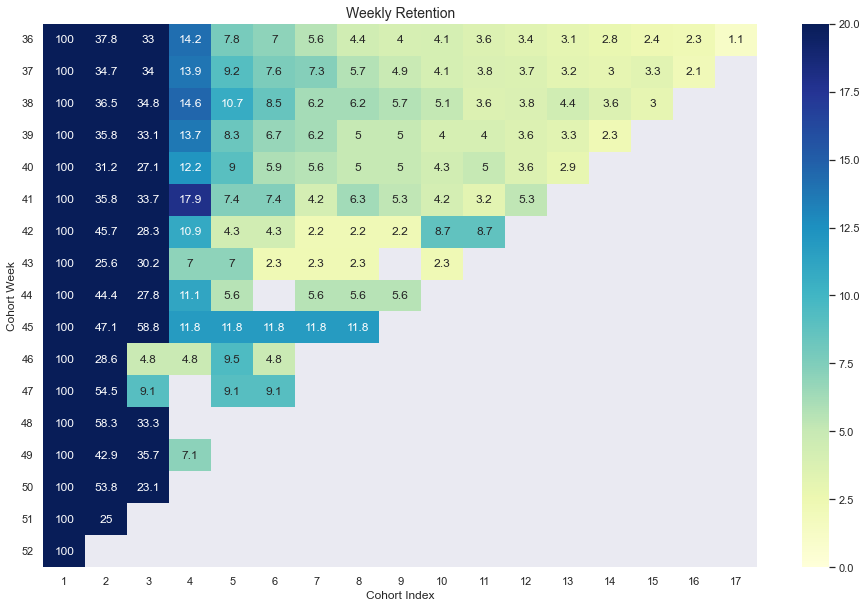

In [33]:
# Наглядно видим недельный Retention
plt.figure(figsize=(16, 10))
plt.title('Weekly Retention', fontsize = 14)

sns.heatmap(retention, annot = True, vmin = 0.0, vmax =20, cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Week')
plt.xlabel('Cohort Index')
plt.yticks(rotation='360')
plt.show()

### Churn rate

In [34]:
# Группируем по "игроку" и выводим его последнюю транзакцию
last_trans=df.groupby('rra_playerId')['rra_dateAt'].max().reset_index()
last_trans

,rra_playerId,rra_dateAt
0,5346033,2020-09-01 03:00:00
1,5346055,2020-10-15 03:00:00
2,5346061,2020-11-18 03:00:00
3,5346068,2020-10-23 03:00:00
4,5346205,2020-09-01 03:00:00
...,...,...
6637,5638103,2020-09-29 03:00:00
6638,5638106,2020-09-29 03:00:00
6639,5638107,2020-10-14 03:00:00
6640,5638129,2020-10-02 03:00:00


In [35]:
# Из последнего транзакционного дня датасета вычитаем дату последней транзакции каждого клиента
last_trans['last_purchase']=df['rra_dateAt'].max()-last_trans['rra_dateAt']
last_trans['last_purchase']=last_trans['last_purchase'].apply(lambda x: x.days)

In [36]:
df['rra_dateAt'].max()

Timestamp('2020-12-24 03:00:00')

In [37]:
# Смотрим, что всё сделано правильно
last_trans.sort_values('last_purchase', ascending=False)

,rra_playerId,rra_dateAt,last_purchase
0,5346033,2020-09-01 03:00:00,114
19,5346805,2020-09-01 03:00:00,114
4,5346205,2020-09-01 03:00:00,114
5,5346268,2020-09-01 03:00:00,114
154,5351136,2020-09-02 03:00:00,113
...,...,...,...
3431,5483500,2020-12-24 03:00:00,0
3955,5507763,2020-12-24 03:00:00,0
6161,5611058,2020-12-24 03:00:00,0
5023,5558185,2020-12-24 03:00:00,0


In [48]:
# Предположим, что "оттёкшими" клиентами считаются те, кто не транзачил > 30 дней
# *можно подставить любое другое кол-во дней
last_trans.loc[last_trans['last_purchase']>30,'Category']=1
last_trans.loc[last_trans['last_purchase']<=30,'Category']=0

In [49]:
# Присоединяем категории к основной колонке
df = df.merge(last_trans, left_on='rra_playerId', right_on='rra_playerId')
df

,rra_id,rra_playerId,rra_dateAt_x,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,...,c_registrationDateAt,c_gender,c_age,registration_week,TransactionWeek,CohortWeek,CohortIndex,rra_dateAt_y,last_purchase,Category
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,...,2020-09-17 11:08:36,m,54.0,3,38,38,1,2020-10-02 03:00:00,83,1.0
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,...,2020-09-17 11:08:36,m,54.0,3,40,38,3,2020-10-02 03:00:00,83,1.0
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,...,2020-09-17 11:53:13,f,55.0,3,38,38,1,2020-11-15 03:00:00,39,1.0
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,...,2020-09-17 11:53:13,f,55.0,3,41,38,4,2020-11-15 03:00:00,39,1.0
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,...,2020-09-17 11:53:13,f,55.0,3,46,38,9,2020-11-15 03:00:00,39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,507503046389541339,5602163,2020-11-11 03:00:00,88092,102,101694,NL,0,0,0.00,...,2020-09-26 13:43:30,m,44.0,4,46,42,5,2020-11-13 03:00:00,41,1.0
28081,922901049461347211,5602163,2020-10-20 03:00:00,88092,102,101694,NL,0,0,0.00,...,2020-09-26 13:43:30,m,44.0,4,43,42,2,2020-11-13 03:00:00,41,1.0
28082,998500453066618518,5602163,2020-10-13 03:00:00,88092,102,101694,NL,0,1,50.00,...,2020-09-26 13:43:30,m,44.0,4,42,42,1,2020-11-13 03:00:00,41,1.0
28083,121761332613496860,5526080,2020-10-23 03:00:00,88092,102,101694,NL,0,0,0.00,...,2020-09-19 11:47:32,f,37.0,3,43,43,1,2020-10-23 03:00:00,62,1.0


In [50]:
last_trans

,rra_playerId,rra_dateAt,last_purchase,Category
0,5346033,2020-09-01 03:00:00,114,1.0
1,5346055,2020-10-15 03:00:00,70,1.0
2,5346061,2020-11-18 03:00:00,36,1.0
3,5346068,2020-10-23 03:00:00,62,1.0
4,5346205,2020-09-01 03:00:00,114,1.0
...,...,...,...,...
6637,5638103,2020-09-29 03:00:00,86,1.0
6638,5638106,2020-09-29 03:00:00,86,1.0
6639,5638107,2020-10-14 03:00:00,71,1.0
6640,5638129,2020-10-02 03:00:00,83,1.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28085 entries, 0 to 28084
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   rra_id                  28085 non-null  int64         
 1   rra_playerId            28085 non-null  int64         
 2   rra_dateAt_x            28085 non-null  datetime64[ns]
 3   rra_partnerId           28085 non-null  int64         
 4   rra_brandId             28085 non-null  int64         
 5   rra_campaignId          28085 non-null  int64         
 6   rra_playerCountry       28085 non-null  object        
 7   rra_registrationsCount  28085 non-null  int64         
 8   rra_depositsCount       28085 non-null  int64         
 9   firstDepositsSumEur     28085 non-null  float64       
 10  depositsSumEur          28085 non-null  float64       
 11  c_registrationDateAt    28085 non-null  datetime64[ns]
 12  c_gender                28085 non-null  object

In [52]:
# Подчищаем недочёты
del df['rra_dateAt_y']
del df['last_purchase']
df = df.rename(columns={"rra_dateAt_x": "rra_dateAt"})

In [53]:
df

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,registration_week,TransactionWeek,CohortWeek,CohortIndex,Category
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0,3,38,38,1,1.0
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0,3,40,38,3,1.0
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0,3,38,38,1,1.0
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0,3,41,38,4,1.0
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0,3,46,38,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,507503046389541339,5602163,2020-11-11 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4,46,42,5,1.0
28081,922901049461347211,5602163,2020-10-20 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4,43,42,2,1.0
28082,998500453066618518,5602163,2020-10-13 03:00:00,88092,102,101694,NL,0,1,50.00,50.00,2020-09-26 13:43:30,m,44.0,4,42,42,1,1.0
28083,121761332613496860,5526080,2020-10-23 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-19 11:47:32,f,37.0,3,43,43,1,1.0


In [54]:
df = df.rename(columns={"rra_dateAt_x": "rra_dateAt"})

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28085 entries, 0 to 28084
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   rra_id                  28085 non-null  int64         
 1   rra_playerId            28085 non-null  int64         
 2   rra_dateAt              28085 non-null  datetime64[ns]
 3   rra_partnerId           28085 non-null  int64         
 4   rra_brandId             28085 non-null  int64         
 5   rra_campaignId          28085 non-null  int64         
 6   rra_playerCountry       28085 non-null  object        
 7   rra_registrationsCount  28085 non-null  int64         
 8   rra_depositsCount       28085 non-null  int64         
 9   firstDepositsSumEur     28085 non-null  float64       
 10  depositsSumEur          28085 non-null  float64       
 11  c_registrationDateAt    28085 non-null  datetime64[ns]
 12  c_gender                28085 non-null  object

In [56]:
# Можем увидеть долю оттока на каждую неделю из датасета
df.groupby('TransactionWeek')['Category'].value_counts(normalize=True)

TransactionWeek  Category
36               1.0         0.934615
                 0.0         0.065385
37               1.0         0.892764
                 0.0         0.107236
38               1.0         0.857105
                 0.0         0.142895
39               1.0         0.844271
                 0.0         0.155729
40               1.0         0.765097
                 0.0         0.234903
41               1.0         0.699818
                 0.0         0.300182
42               1.0         0.574440
                 0.0         0.425560
43               0.0         0.502467
                 1.0         0.497533
44               0.0         0.630370
                 1.0         0.369630
45               0.0         0.658363
                 1.0         0.341637
46               0.0         0.750000
                 1.0         0.250000
47               0.0         0.823699
                 1.0         0.176301
48               0.0         0.982583
                 1.0    

### ARPWAU

In [57]:
df

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,registration_week,TransactionWeek,CohortWeek,CohortIndex,Category
0,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0,3,38,38,1,1.0
1,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0,3,40,38,3,1.0
2,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0,3,38,38,1,1.0
3,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0,3,41,38,4,1.0
4,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0,3,46,38,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,507503046389541339,5602163,2020-11-11 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4,46,42,5,1.0
28081,922901049461347211,5602163,2020-10-20 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-26 13:43:30,m,44.0,4,43,42,2,1.0
28082,998500453066618518,5602163,2020-10-13 03:00:00,88092,102,101694,NL,0,1,50.00,50.00,2020-09-26 13:43:30,m,44.0,4,42,42,1,1.0
28083,121761332613496860,5526080,2020-10-23 03:00:00,88092,102,101694,NL,0,0,0.00,0.00,2020-09-19 11:47:32,f,37.0,3,43,43,1,1.0


In [58]:
df.groupby(df['TransactionWeek'])[['rra_playerId']].count()

,rra_playerId
TransactionWeek,
36,1820
37,3441
38,3772
39,4617
40,3312
41,2192
42,1518
43,1216
44,1001


In [59]:
df.groupby(df['TransactionWeek'])[['depositsSumEur']].sum()

,depositsSumEur
TransactionWeek,
36,100791.21
37,204189.83
38,191662.19
39,251603.11
40,183679.55
41,108159.81
42,146620.28
43,162380.45
44,74210.84


In [60]:
# Делаем простую функцию для деления двух колонок в groupby 
def divide_two_cols(df_sub):
    return df_sub['depositsSumEur'].sum() / float(df_sub['rra_playerId'].count())
# Выводим среднюю сумму транзакций на клиента в разрезе транзакционных недель
df.groupby('TransactionWeek').apply(divide_two_cols)

TransactionWeek
36     55.379786
37     59.340259
38     50.811821
39     54.494934
40     55.458801
41     49.342979
42     96.587800
43    133.536554
44     74.136703
45     89.679573
46     89.669431
47     88.706040
48    110.383382
49     95.905391
50     97.732381
51    103.842542
52     88.838488
dtype: float64

# Построение модели

In [61]:
# Считаем сумму всех транзакции на клиента
m = df.groupby('rra_playerId')['depositsSumEur'].mean()
m = pd.DataFrame(m).reset_index()
m

,rra_playerId,depositsSumEur
0,5346033,10.540000
1,5346055,11.082000
2,5346061,3.834000
3,5346068,1.190000
4,5346205,40.000000
...,...,...
6637,5638103,50.000000
6638,5638106,25.000000
6639,5638107,6.666667
6640,5638129,180.000000


In [62]:
# Считаем кол-во транзакций на клиента за наш период
freq = df.groupby('rra_playerId')['rra_dateAt'].count()
f = pd.DataFrame(freq).reset_index()
f = f.rename(columns = {'rra_dateAt': 'frequency'})
f

,rra_playerId,frequency
0,5346033,1
1,5346055,5
2,5346061,5
3,5346068,13
4,5346205,1
...,...,...
6637,5638103,1
6638,5638106,1
6639,5638107,3
6640,5638129,1


In [63]:
# Рассчитываем последний день транзакции клиента, относительно наших данных
df['Date']= pd.to_datetime(df['rra_dateAt'])
df['rank'] = df.sort_values(['rra_playerId','Date']).groupby(['rra_playerId'])['Date'].rank(method='min').astype(int)
recent = df[df['rank']==1]
recent['recency'] = recent['Date'] - pd.to_datetime(df['rra_dateAt'].min())

def recency(recency):
    res = str(recency).split(' ')[0]
    return(int(res))
    
recent['recency'] = recent['recency'].apply(recency)

recent = recent[['rra_playerId','recency']]
recent = recent.drop_duplicates()

In [64]:
# Функция для рассчёта кол-ва дней наблюдения за клиентом
def minus_two_cols(df_plus):
    res = (pd.to_datetime("today") - df_plus['rra_dateAt'].min() + timedelta(days=90)).days
    return res

In [65]:
# Рассчитываем кол-во дней наблюдения за клиентом
t = df.groupby('rra_playerId').apply(minus_two_cols).sort_values()
t = pd.DataFrame(t).reset_index()
t.columns = 'rra_playerId', 'T'
t

,rra_playerId,T
0,5417764,374
1,5448586,374
2,5489558,374
3,5519150,375
4,5384752,375
...,...,...
6637,5347062,488
6638,5347207,488
6639,5347238,488
6640,5346708,488


In [66]:
# Соединяем всё воедино
finaldf = f.merge(m,on='rra_playerId').merge(recent,on='rra_playerId').merge(t,on='rra_playerId')
finaldf

,rra_playerId,frequency,depositsSumEur,recency,T
0,5346033,1,10.540000,0,488
1,5346055,5,11.082000,0,488
2,5346061,5,3.834000,0,488
3,5346068,13,1.190000,0,488
4,5346205,1,40.000000,0,488
...,...,...,...,...,...
6637,5638103,1,50.000000,28,460
6638,5638106,1,25.000000,28,460
6639,5638107,3,6.666667,28,460
6640,5638129,1,180.000000,31,457


In [67]:
# Фитуем модель
bgf = BetaGeoFitter()
bgf.fit(finaldf['frequency'], finaldf['recency'], finaldf['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 6642 subjects, a: 2.31, alpha: 1.36, b: 4.13, r: 0.68>

In [68]:
# Предсказываем кол-во "покупок" на каждого клиента на ~ 90/180/360 дней
t_90 = 1
t_180 = 2
t_360 = 4
finaldf['90_predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t_90,
                                                                                            finaldf['frequency'],
                                                                                            finaldf['recency'],
                                                                                            finaldf['T'])
finaldf['180_predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t_180,
                                                                                            finaldf['frequency'],
                                                                                            finaldf['recency'],
                                                                                            finaldf['T'])
finaldf['360_predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t_360,
                                                                                            finaldf['frequency'],
                                                                                            finaldf['recency'],
                                                                                            finaldf['T'])

In [69]:
# Результат
finaldf

,rra_playerId,frequency,depositsSumEur,recency,T,90_predicted_purchases,180_predicted_purchases,360_predicted_purchases
0,5346033,1,10.540000,0,488,3.102779e-07,6.200287e-07,1.237955e-06
1,5346055,5,11.082000,0,488,1.228027e-16,2.452675e-16,4.891891e-16
2,5346061,5,3.834000,0,488,1.228027e-16,2.452675e-16,4.891891e-16
3,5346068,13,1.190000,0,488,2.074997e-36,4.142616e-36,8.255873e-36
4,5346205,1,40.000000,0,488,3.102779e-07,6.200287e-07,1.237955e-06
...,...,...,...,...,...,...,...,...
6637,5638103,1,50.000000,28,460,6.238306e-05,1.246537e-04,2.488593e-04
6638,5638106,1,25.000000,28,460,6.238306e-05,1.246537e-04,2.488593e-04
6639,5638107,3,6.666667,28,460,8.354876e-07,1.668905e-06,3.329560e-06
6640,5638129,1,180.000000,31,457,7.451334e-05,1.488916e-04,2.972444e-04


In [70]:
# Рассчитанная прибыль
finaldf['90_predicted_revenue'] = finaldf['depositsSumEur'] * finaldf['90_predicted_purchases']
finaldf['180_predicted_revenue'] = finaldf['depositsSumEur'] * finaldf['180_predicted_purchases']
finaldf['360_predicted_revenue'] = finaldf['depositsSumEur'] * finaldf['360_predicted_purchases']

In [71]:
finaldf

,rra_playerId,frequency,depositsSumEur,recency,T,90_predicted_purchases,180_predicted_purchases,360_predicted_purchases,90_predicted_revenue,180_predicted_revenue,360_predicted_revenue
0,5346033,1,10.540000,0,488,3.102779e-07,6.200287e-07,1.237955e-06,3.270329e-06,6.535103e-06,1.304805e-05
1,5346055,5,11.082000,0,488,1.228027e-16,2.452675e-16,4.891891e-16,1.360899e-15,2.718054e-15,5.421194e-15
2,5346061,5,3.834000,0,488,1.228027e-16,2.452675e-16,4.891891e-16,4.708254e-16,9.403555e-16,1.875551e-15
3,5346068,13,1.190000,0,488,2.074997e-36,4.142616e-36,8.255873e-36,2.469247e-36,4.929713e-36,9.824489e-36
4,5346205,1,40.000000,0,488,3.102779e-07,6.200287e-07,1.237955e-06,1.241112e-05,2.480115e-05,4.951822e-05
...,...,...,...,...,...,...,...,...,...,...,...
6637,5638103,1,50.000000,28,460,6.238306e-05,1.246537e-04,2.488593e-04,3.119153e-03,6.232686e-03,1.244297e-02
6638,5638106,1,25.000000,28,460,6.238306e-05,1.246537e-04,2.488593e-04,1.559576e-03,3.116343e-03,6.221483e-03
6639,5638107,3,6.666667,28,460,8.354876e-07,1.668905e-06,3.329560e-06,5.569918e-06,1.112603e-05,2.219707e-05
6640,5638129,1,180.000000,31,457,7.451334e-05,1.488916e-04,2.972444e-04,1.341240e-02,2.680048e-02,5.350399e-02
